In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np

import os
import json
import pickle as pickle

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import trackintel as ti

In [2]:
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

matplotlib.rcParams["figure.dpi"] = 300
matplotlib.rcParams["xtick.labelsize"] = 13
matplotlib.rcParams["ytick.labelsize"] = 13
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

%matplotlib inline

In [3]:
DATA_DIR = os.path.join("..", "paths.json")
with open(DATA_DIR) as json_file:
    CONFIG = json.load(json_file)

save_dir = os.path.join("..", CONFIG["data_dir"])

# Calculate tracking quality
## Read files

In [4]:
selected_pfs = ti.read_positionfixes_csv(os.path.join(save_dir, "selected_geolife_pfs.csv"), index_col="id")
selected_mode_labels = pickle.load(open(os.path.join(save_dir, "selected_mode_labels.pk"), "rb"))

In [5]:
# validate
len(selected_pfs), selected_mode_labels.keys()

(4396670, dict_keys([20, 112, 154]))

## Generate staypoints and trips 

In [6]:
# generate staypoints, triplegs and trips
pfs, sp = selected_pfs.generate_staypoints(gap_threshold=24 * 60, include_last=True, print_progress=True, dist_threshold=200, time_threshold=30, n_jobs=-1)

# create activity flag
sp = sp.create_activity_flag(method="time_threshold", time_threshold=25)

# generate triplegs
pfs, tpls = pfs.generate_triplegs(sp, gap_threshold=15, print_progress=True)

# generate trips
sp, tpls, trips = sp.generate_trips(tpls, add_geometry=False)

c:\ProgramData\Anaconda3\envs\reprotrack\lib\site-packages\trackintel\preprocessing\positionfixes.py:113: UserWarning: 1690 duplicates were dropped from your positionfixes. Dropping duplicates is recommended but can be prevented using the 'exclude_duplicate_pfs' flag.
  warnings.warn(warn_str)
100%|██████████| 20/20 [00:00<00:00, 55.24it/s]
c:\ProgramData\Anaconda3\envs\reprotrack\lib\site-packages\trackintel\preprocessing\positionfixes.py:508: UserWarning: The positionfixes with ids [2894106 2894107 3826247 3826248] lead to invalid tripleg geometries. The resulting triplegs were omitted and the tripleg id of the positionfixes was set to nan
  warnings.warn(warn_string)


## Calculate tracking quality

In [7]:
# prepare for calculating the tracking quality

trips["started_at"] = pd.to_datetime(trips["started_at"]).dt.tz_localize(None)
trips["finished_at"] = pd.to_datetime(trips["finished_at"]).dt.tz_localize(None)
sp["started_at"] = pd.to_datetime(sp["started_at"]).dt.tz_localize(None)
sp["finished_at"] = pd.to_datetime(sp["finished_at"]).dt.tz_localize(None)

# merge trips and staypoints
print("starting merge", sp.shape, trips.shape)
sp["type"] = "sp"
trips["type"] = "tpl"
df_all = pd.concat([sp, trips])
df_all = ti.analysis.tracking_quality._split_overlaps(df_all, granularity="day")
df_all["duration"] = (df_all["finished_at"] - df_all["started_at"]).dt.total_seconds()
print("finished merge", df_all.shape)
print("*" * 50)

print("Total user number: ", len(df_all["user_id"].unique()))

starting merge (5182, 8) (5531, 5)
finished merge (11985, 12)
**************************************************
Total user number:  20


### Overall quality

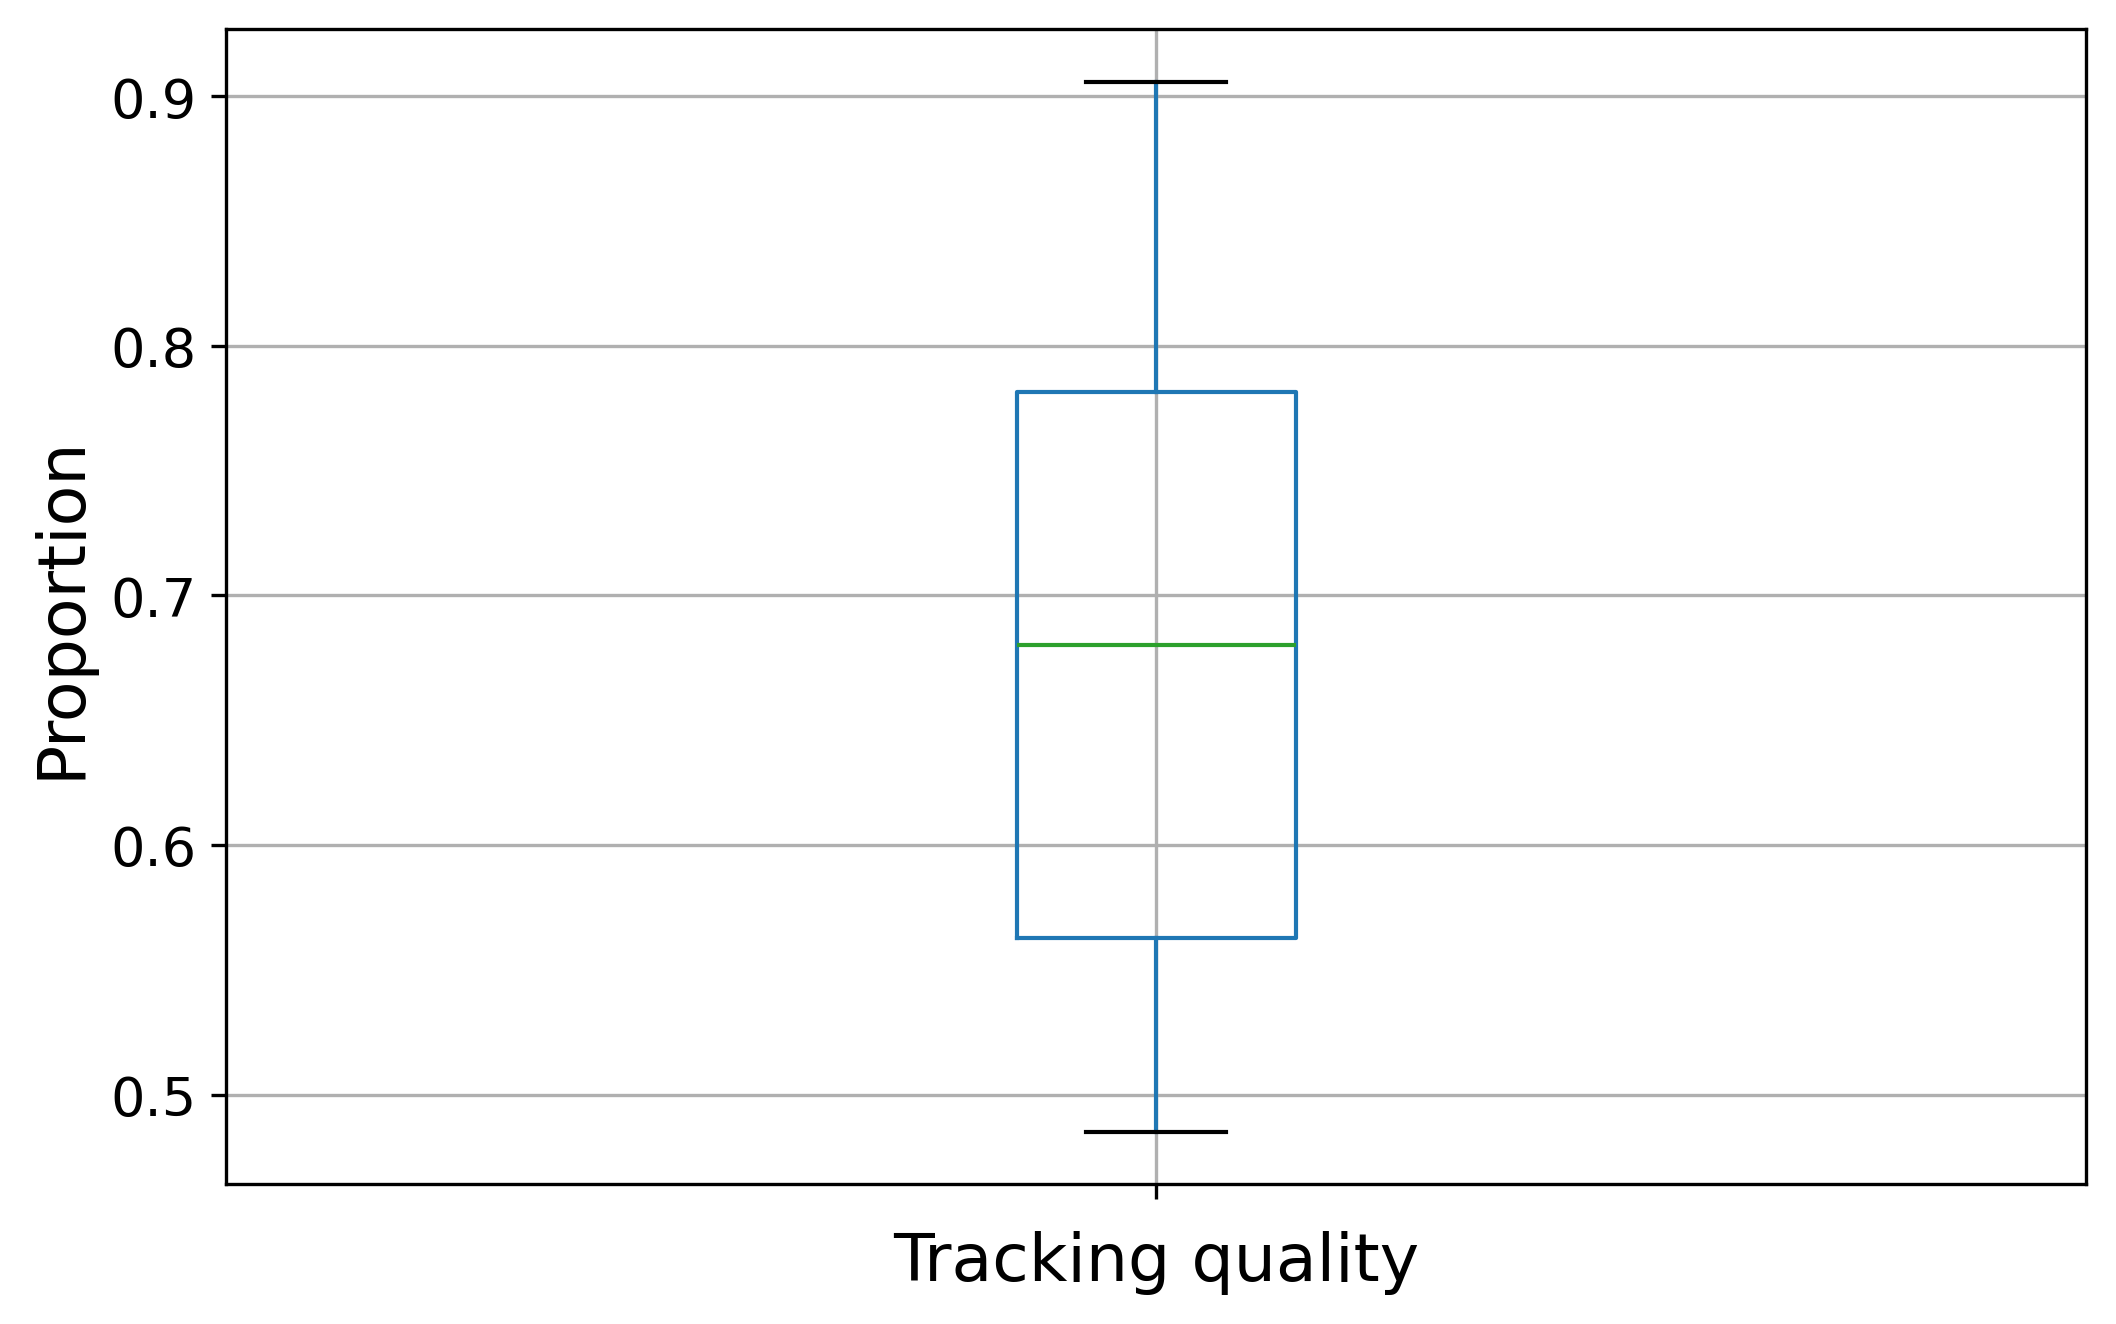

In [8]:
# get quality
total_quality = ti.analysis.temporal_tracking_quality(df_all, granularity="all")

boxplot = total_quality.boxplot(column="quality", figsize=(8, 5))

boxplot.set_xticklabels([])

plt.xlabel("Tracking quality", fontsize=16)
plt.ylabel("Proportion", fontsize=16)
plt.show()

### Quality by week

In [9]:
# get quality
week_quality = ti.analysis.temporal_tracking_quality(df_all, granularity="week")

week_quality_user = week_quality.loc[week_quality["quality"] != 0].groupby("week_monday", as_index=False)["quality"].median()

# construct the index
week_quality_user.set_index("week_monday",inplace=True)

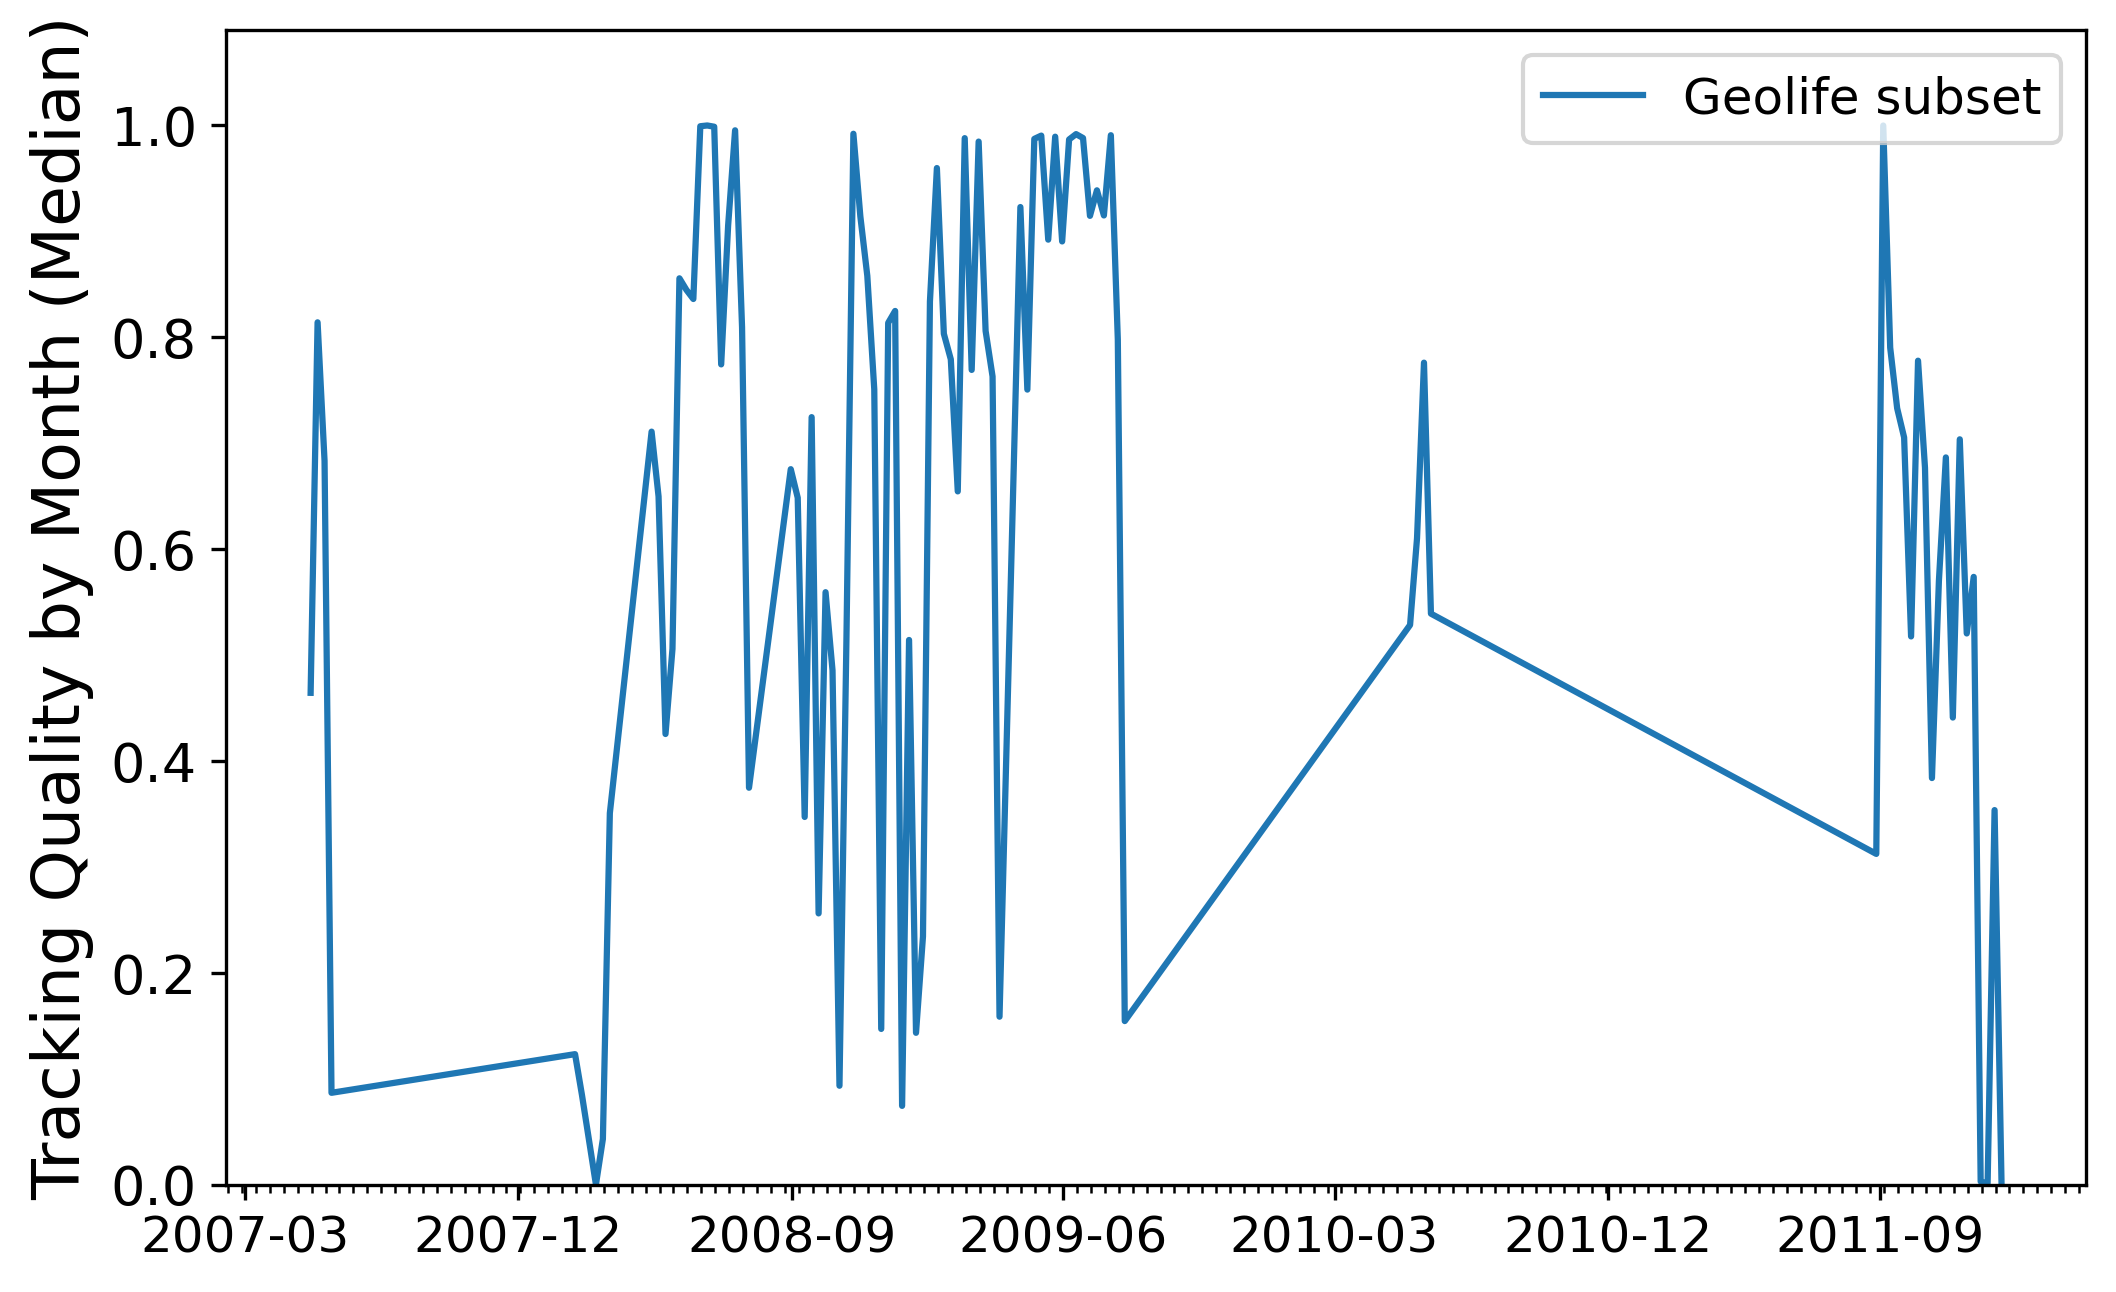

In [10]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(week_quality_user.index, week_quality_user['quality'], label="Geolife subset", color=colors[0])
ax.set_ylabel("Tracking Quality by Month (Median)", fontsize=16)
ax.set_xlabel("", fontsize=16)

ax.xaxis.set_minor_locator(mdates.DayLocator(interval=14))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=9))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

ax.tick_params(axis='x', which='major', labelsize=12)

ax.set_ylim([0, 1.09])
ax.legend(prop={'size': 12}, loc = 'upper right')

plt.show()

### Quality by day

In [11]:
# get quality
day_quality = ti.analysis.temporal_tracking_quality(df_all, granularity="day")

day_quality_user = day_quality.loc[day_quality["quality"] != 0].groupby("day", as_index=False)["quality"].median()
# construct the index
day_quality_user.set_index("day",inplace=True)

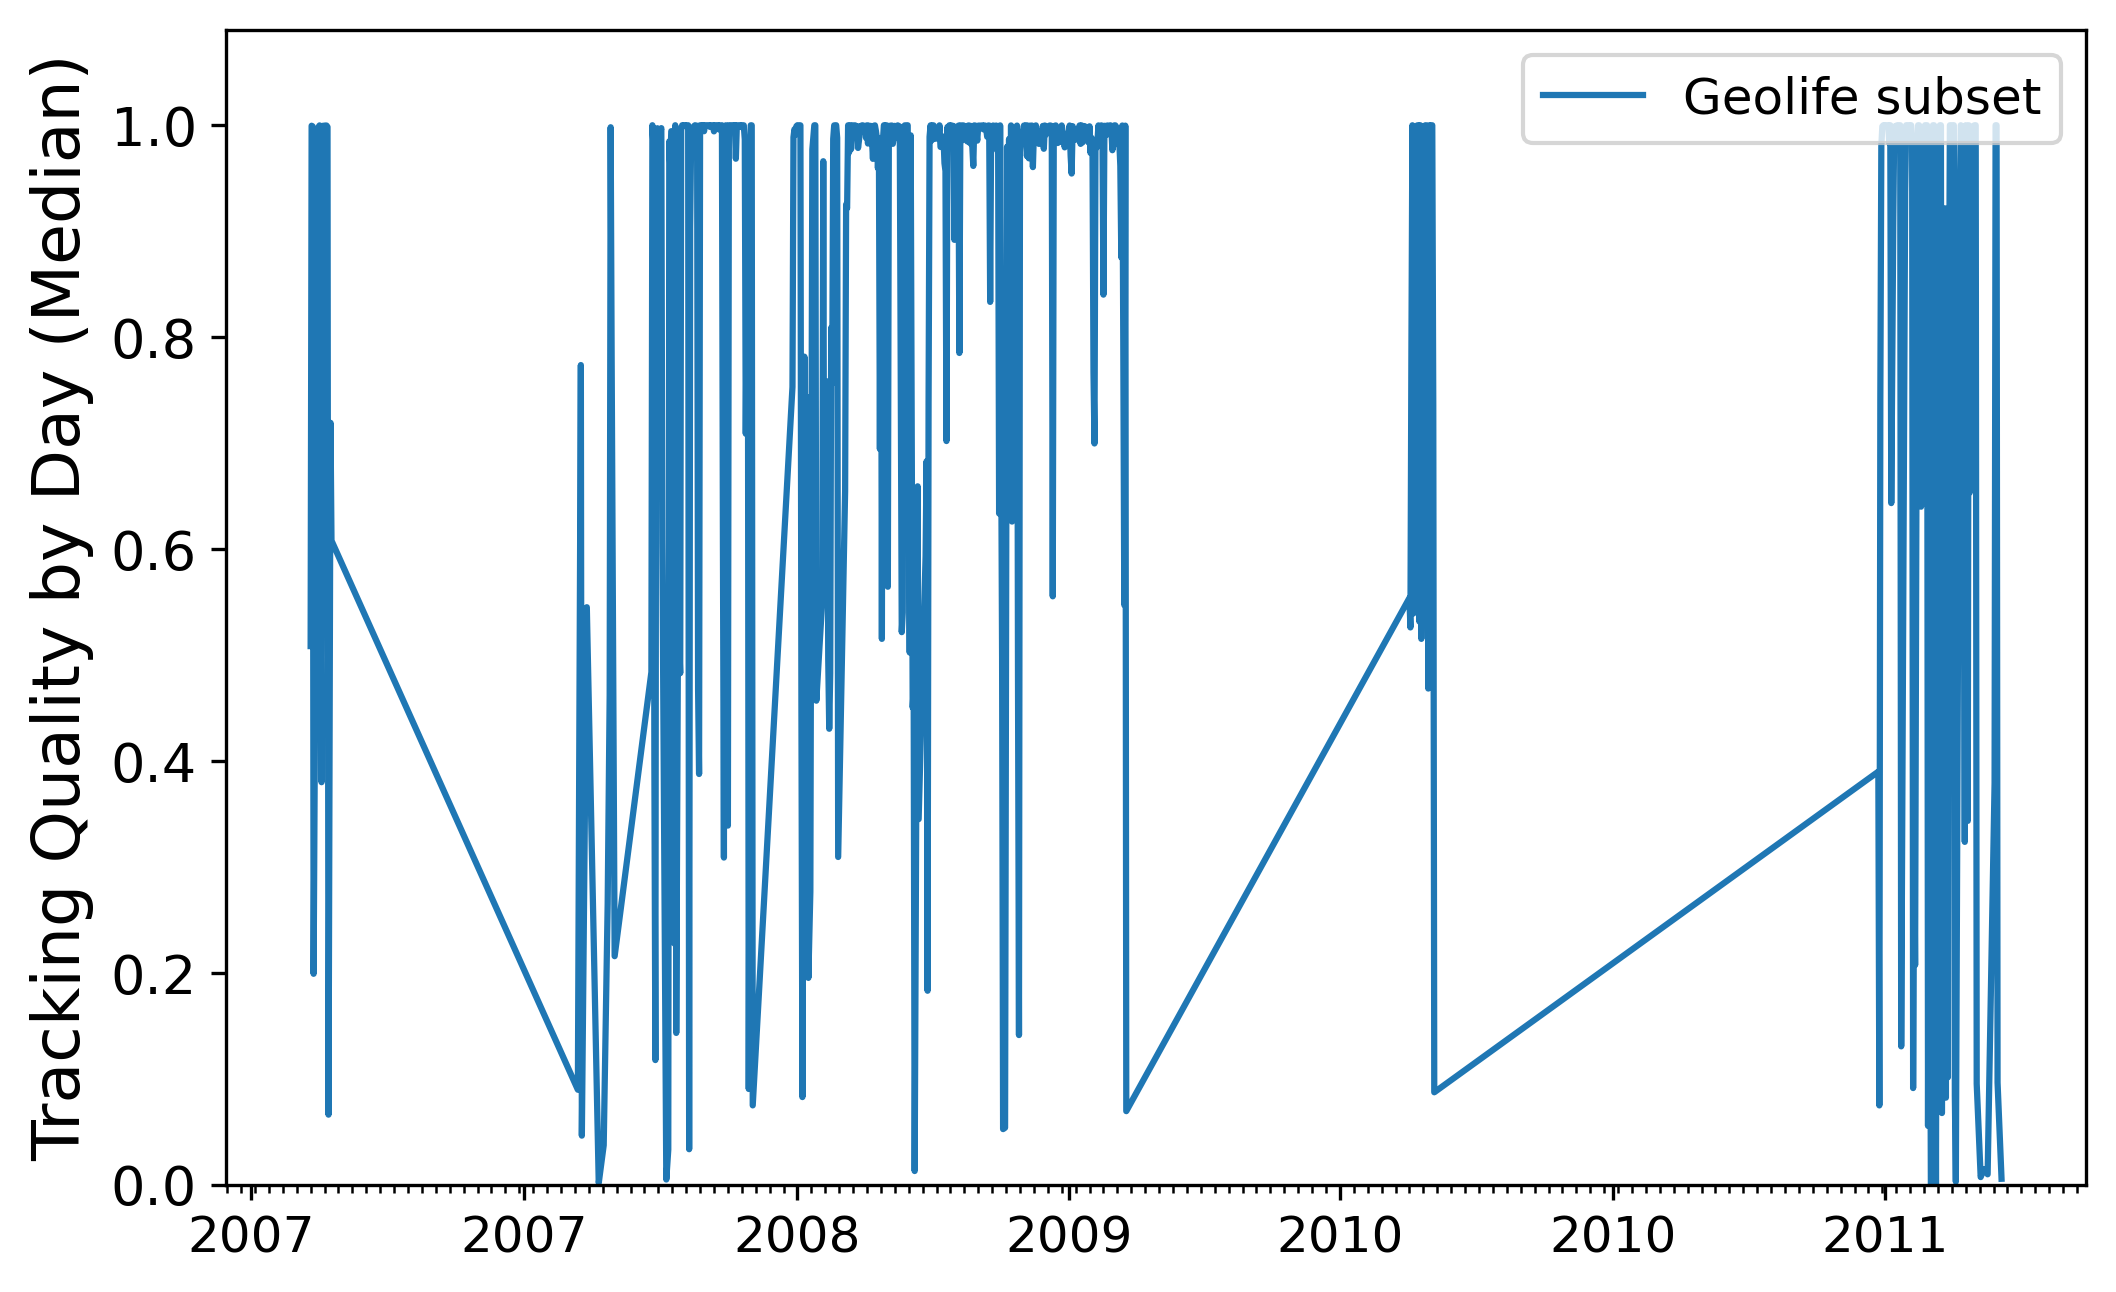

In [12]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(day_quality_user.index, day_quality_user['quality'], label="Geolife subset", color=colors[0])
ax.set_ylabel("Tracking Quality by Day (Median)", fontsize=16)
ax.set_xlabel("", fontsize=16)

ax.xaxis.set_minor_locator(mdates.DayLocator(interval=14))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=9))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

ax.tick_params(axis='x', which='major', labelsize=12)

ax.set_ylim([0, 1.09])
ax.legend(prop={'size': 12}, loc = 'upper right')

plt.show()

### Quality by weekday

In [13]:
# get quality
weekday_quality = ti.analysis.temporal_tracking_quality(df_all, granularity="weekday")

weekday_quality_user = weekday_quality.loc[weekday_quality["quality"] != 0].groupby("weekday", as_index=False)["quality"].median()

weekday_quality_user.set_index("weekday",inplace=True)

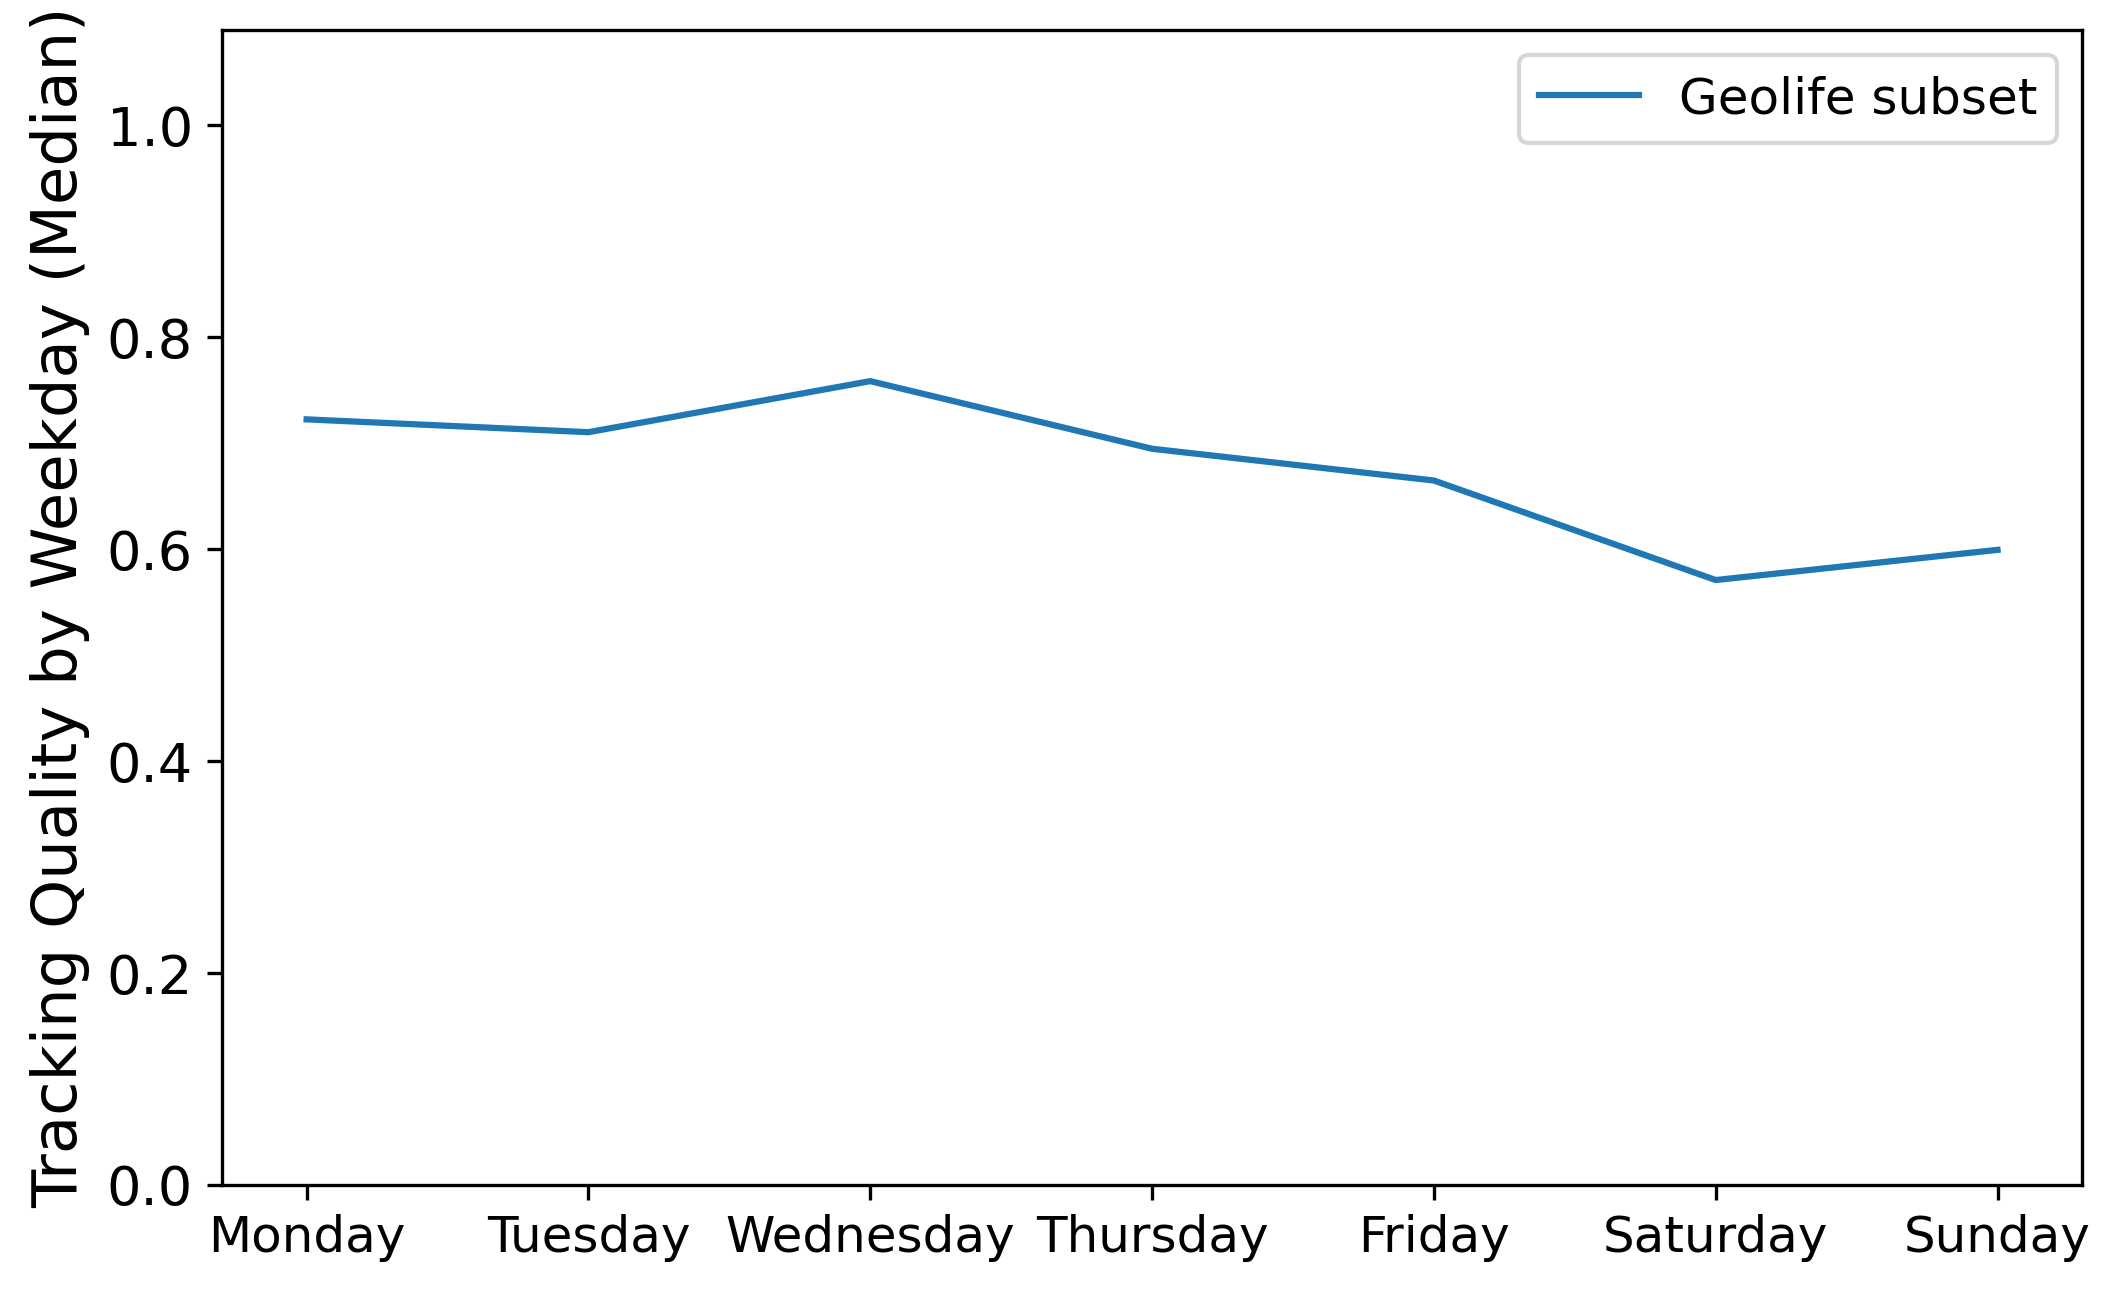

In [14]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(weekday_quality_user.index, weekday_quality_user['quality'], label="Geolife subset", color=colors[0])
ax.set_ylabel("Tracking Quality by Weekday (Median)", fontsize=15)
ax.set_xlabel("", fontsize=15)

ax.tick_params(axis='x', which='major', labelsize=12)

ax.set_ylim([0, 1.09])
ax.set_xticks(np.arange(7), labels= ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

ax.legend(prop={'size': 12}, loc = 'upper right')

plt.show()

### Quality by hour

In [15]:
# get quality
hour_quality = ti.analysis.temporal_tracking_quality(df_all, granularity="hour")

hour_quality_user = hour_quality.loc[hour_quality["quality"] != 0].groupby("hour", as_index=False)["quality"].median()

hour_quality_user.set_index("hour",inplace=True)

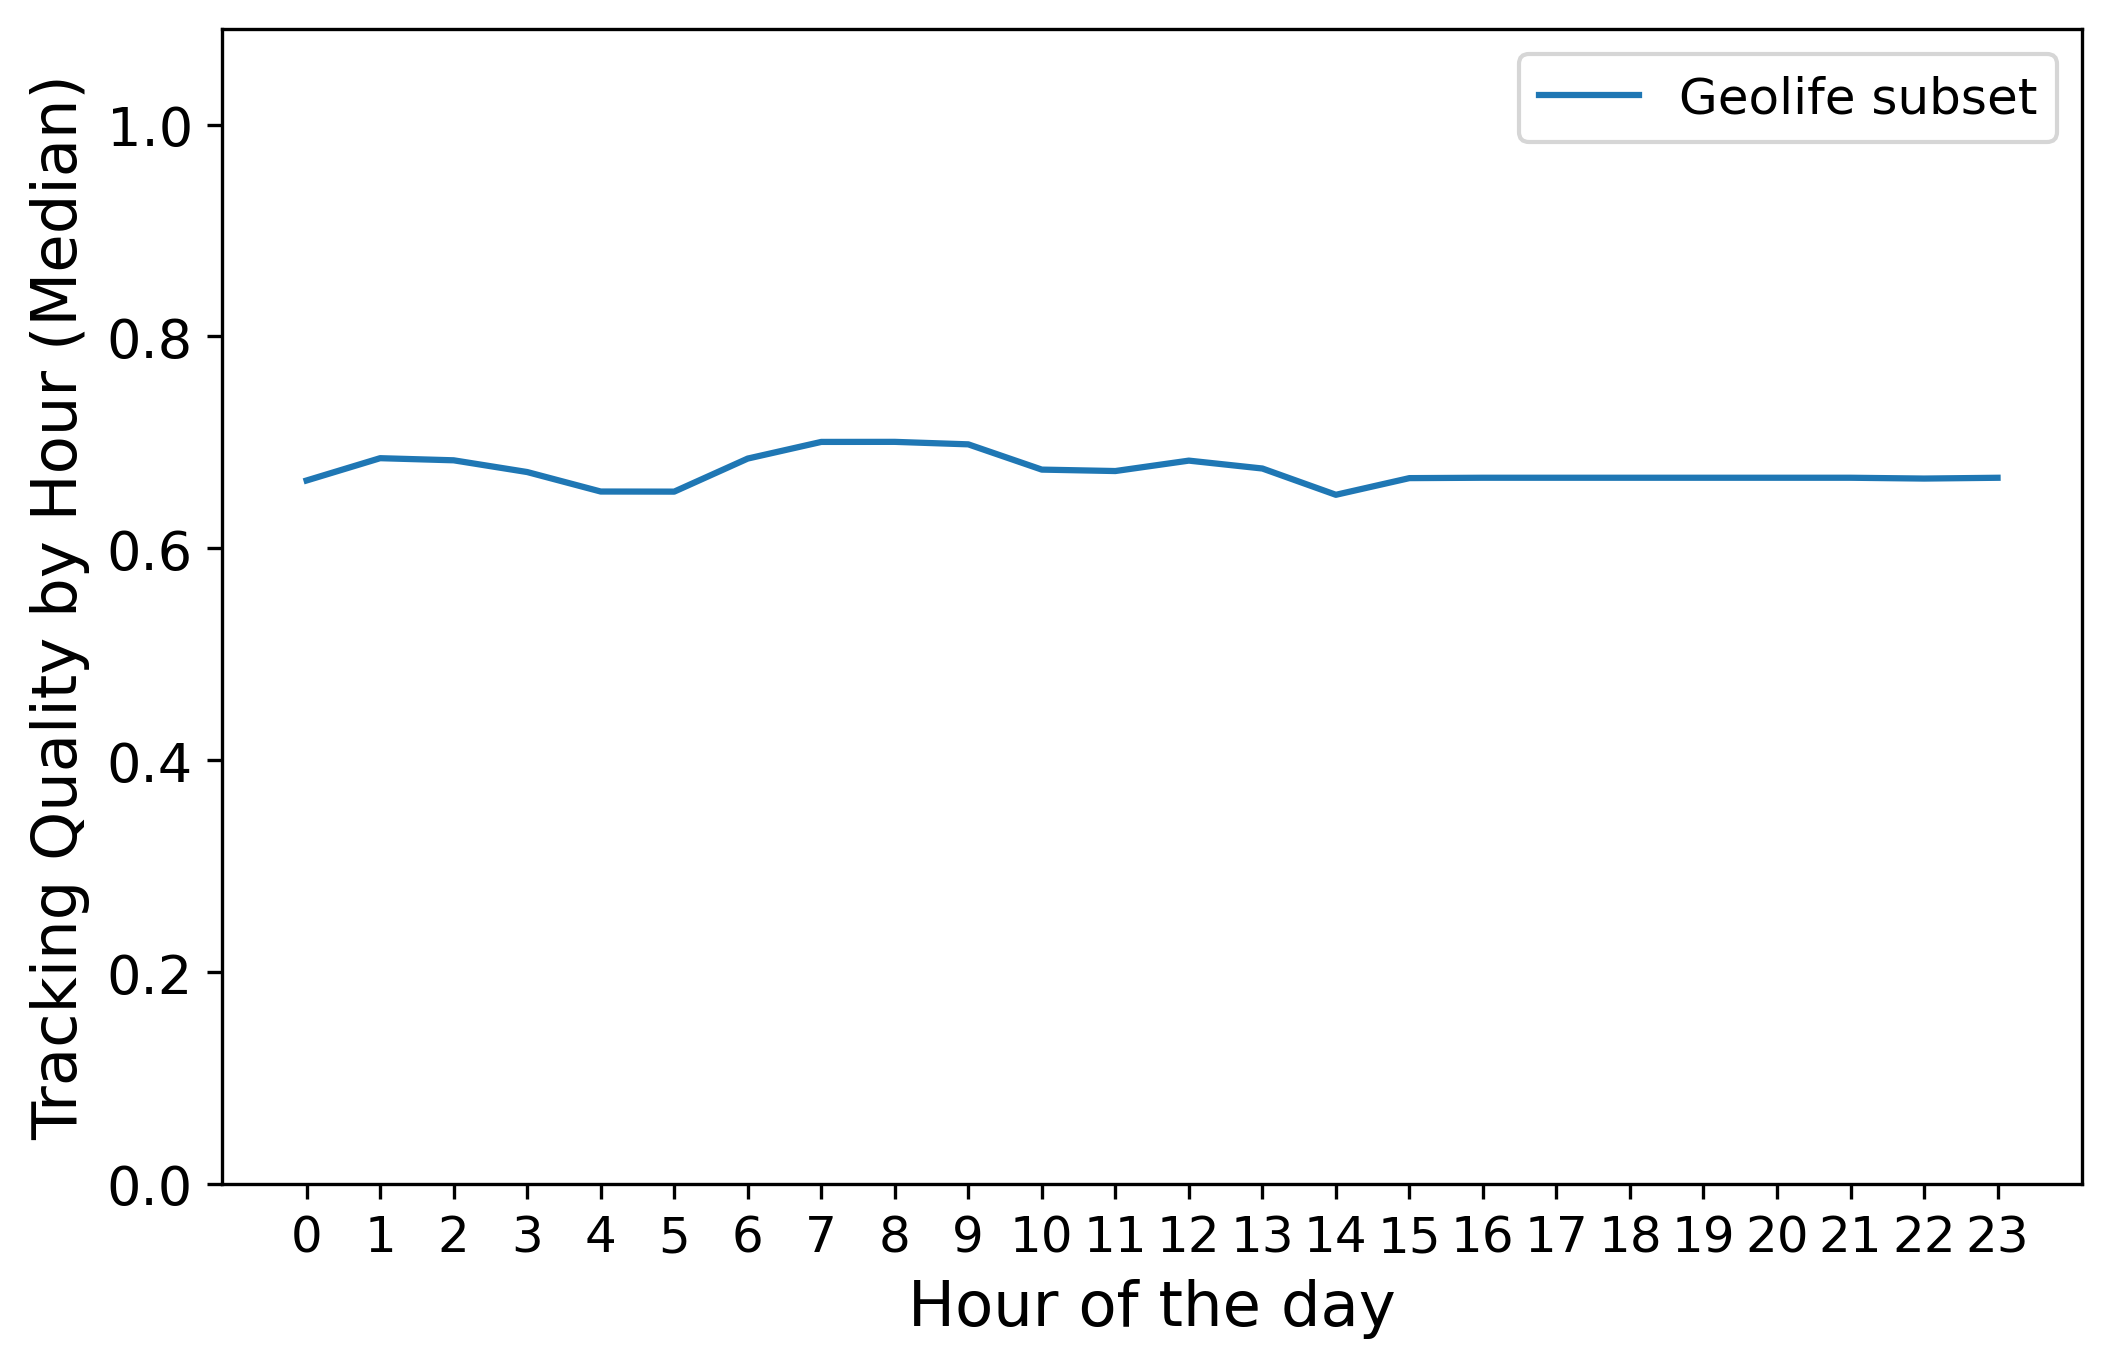

In [16]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(hour_quality_user.index, hour_quality_user['quality'], label="Geolife subset", color=colors[0])
ax.set_ylabel("Tracking Quality by Hour (Median)", fontsize=15)
ax.set_xlabel("", fontsize=15)

ax.tick_params(axis='x', which='major', labelsize=12)

ax.set_ylim([0, 1.09])
ax.set_xticks(np.arange(24))
ax.set_xlabel("Hour of the day", fontsize=15)

ax.legend(prop={'size': 12}, loc = 'upper right')

plt.show()

# Calculate travel mode split
## Read files

In [6]:
selected_pfs = ti.read_positionfixes_csv(os.path.join(save_dir, "selected_geolife_pfs.csv"), index_col="id", crs="EPSG:4326")
selected_mode_labels = pickle.load(open(os.path.join(save_dir, "selected_mode_labels.pk"), "rb"))

# validate
len(selected_pfs), selected_mode_labels.keys()

## Generate staypoints and triplegs

In [8]:
# generate staypoints, triplegs and trips
pfs, sp = selected_pfs.generate_staypoints(gap_threshold=24 * 60, include_last=True, print_progress=True, dist_threshold=200, time_threshold=30, n_jobs=-1)

# create activity flag
sp = sp.create_activity_flag(method="time_threshold", time_threshold=25)

# generate triplegs
pfs, tpls = pfs.generate_triplegs(sp, gap_threshold=15, print_progress=True)

c:\ProgramData\Anaconda3\envs\reprotrack\lib\site-packages\trackintel\preprocessing\positionfixes.py:113: UserWarning: 1690 duplicates were dropped from your positionfixes. Dropping duplicates is recommended but can be prevented using the 'exclude_duplicate_pfs' flag.
  warnings.warn(warn_str)
100%|██████████| 20/20 [00:00<00:00, 56.96it/s]
c:\ProgramData\Anaconda3\envs\reprotrack\lib\site-packages\trackintel\preprocessing\positionfixes.py:508: UserWarning: The positionfixes with ids [2894106 2894107 3826247 3826248] lead to invalid tripleg geometries. The resulting triplegs were omitted and the tripleg id of the positionfixes was set to nan
  warnings.warn(warn_string)


In [9]:
# assign the true mode labels to triplegs, with the help of trackintel functions
tpls = ti.io.geolife_add_modes_to_triplegs(tpls, selected_mode_labels)

# impute the mode of the other triplegs based on speed 
tpls["pred_mode"] = ti.analysis.predict_transport_mode(tpls)["mode"]
tpls.loc[tpls["mode"].isna(), "mode"] = tpls.loc[tpls["mode"].isna(), "pred_mode"]
tpls.drop(columns={"pred_mode"}, inplace=True)

In [10]:
mode_to_category = {
    "fast_mobility": "fast",
    "car": "motorized",
    "bus": "motorized",
    "taxi": "motorized",
    "ecar": "motorized",
    "motorized_mobility": "motorized",
    "bike": "slow",
    "walk": "slow",
    "slow_mobility": "slow",
}

# change mode labels with the above mapping
tpls["mode"] = tpls["mode"].map(mode_to_category)
tpls.dropna(subset=["mode"], inplace=True)
tpls["mode"].value_counts()

mode
slow         3460
motorized    2032
fast           37
Name: count, dtype: int64

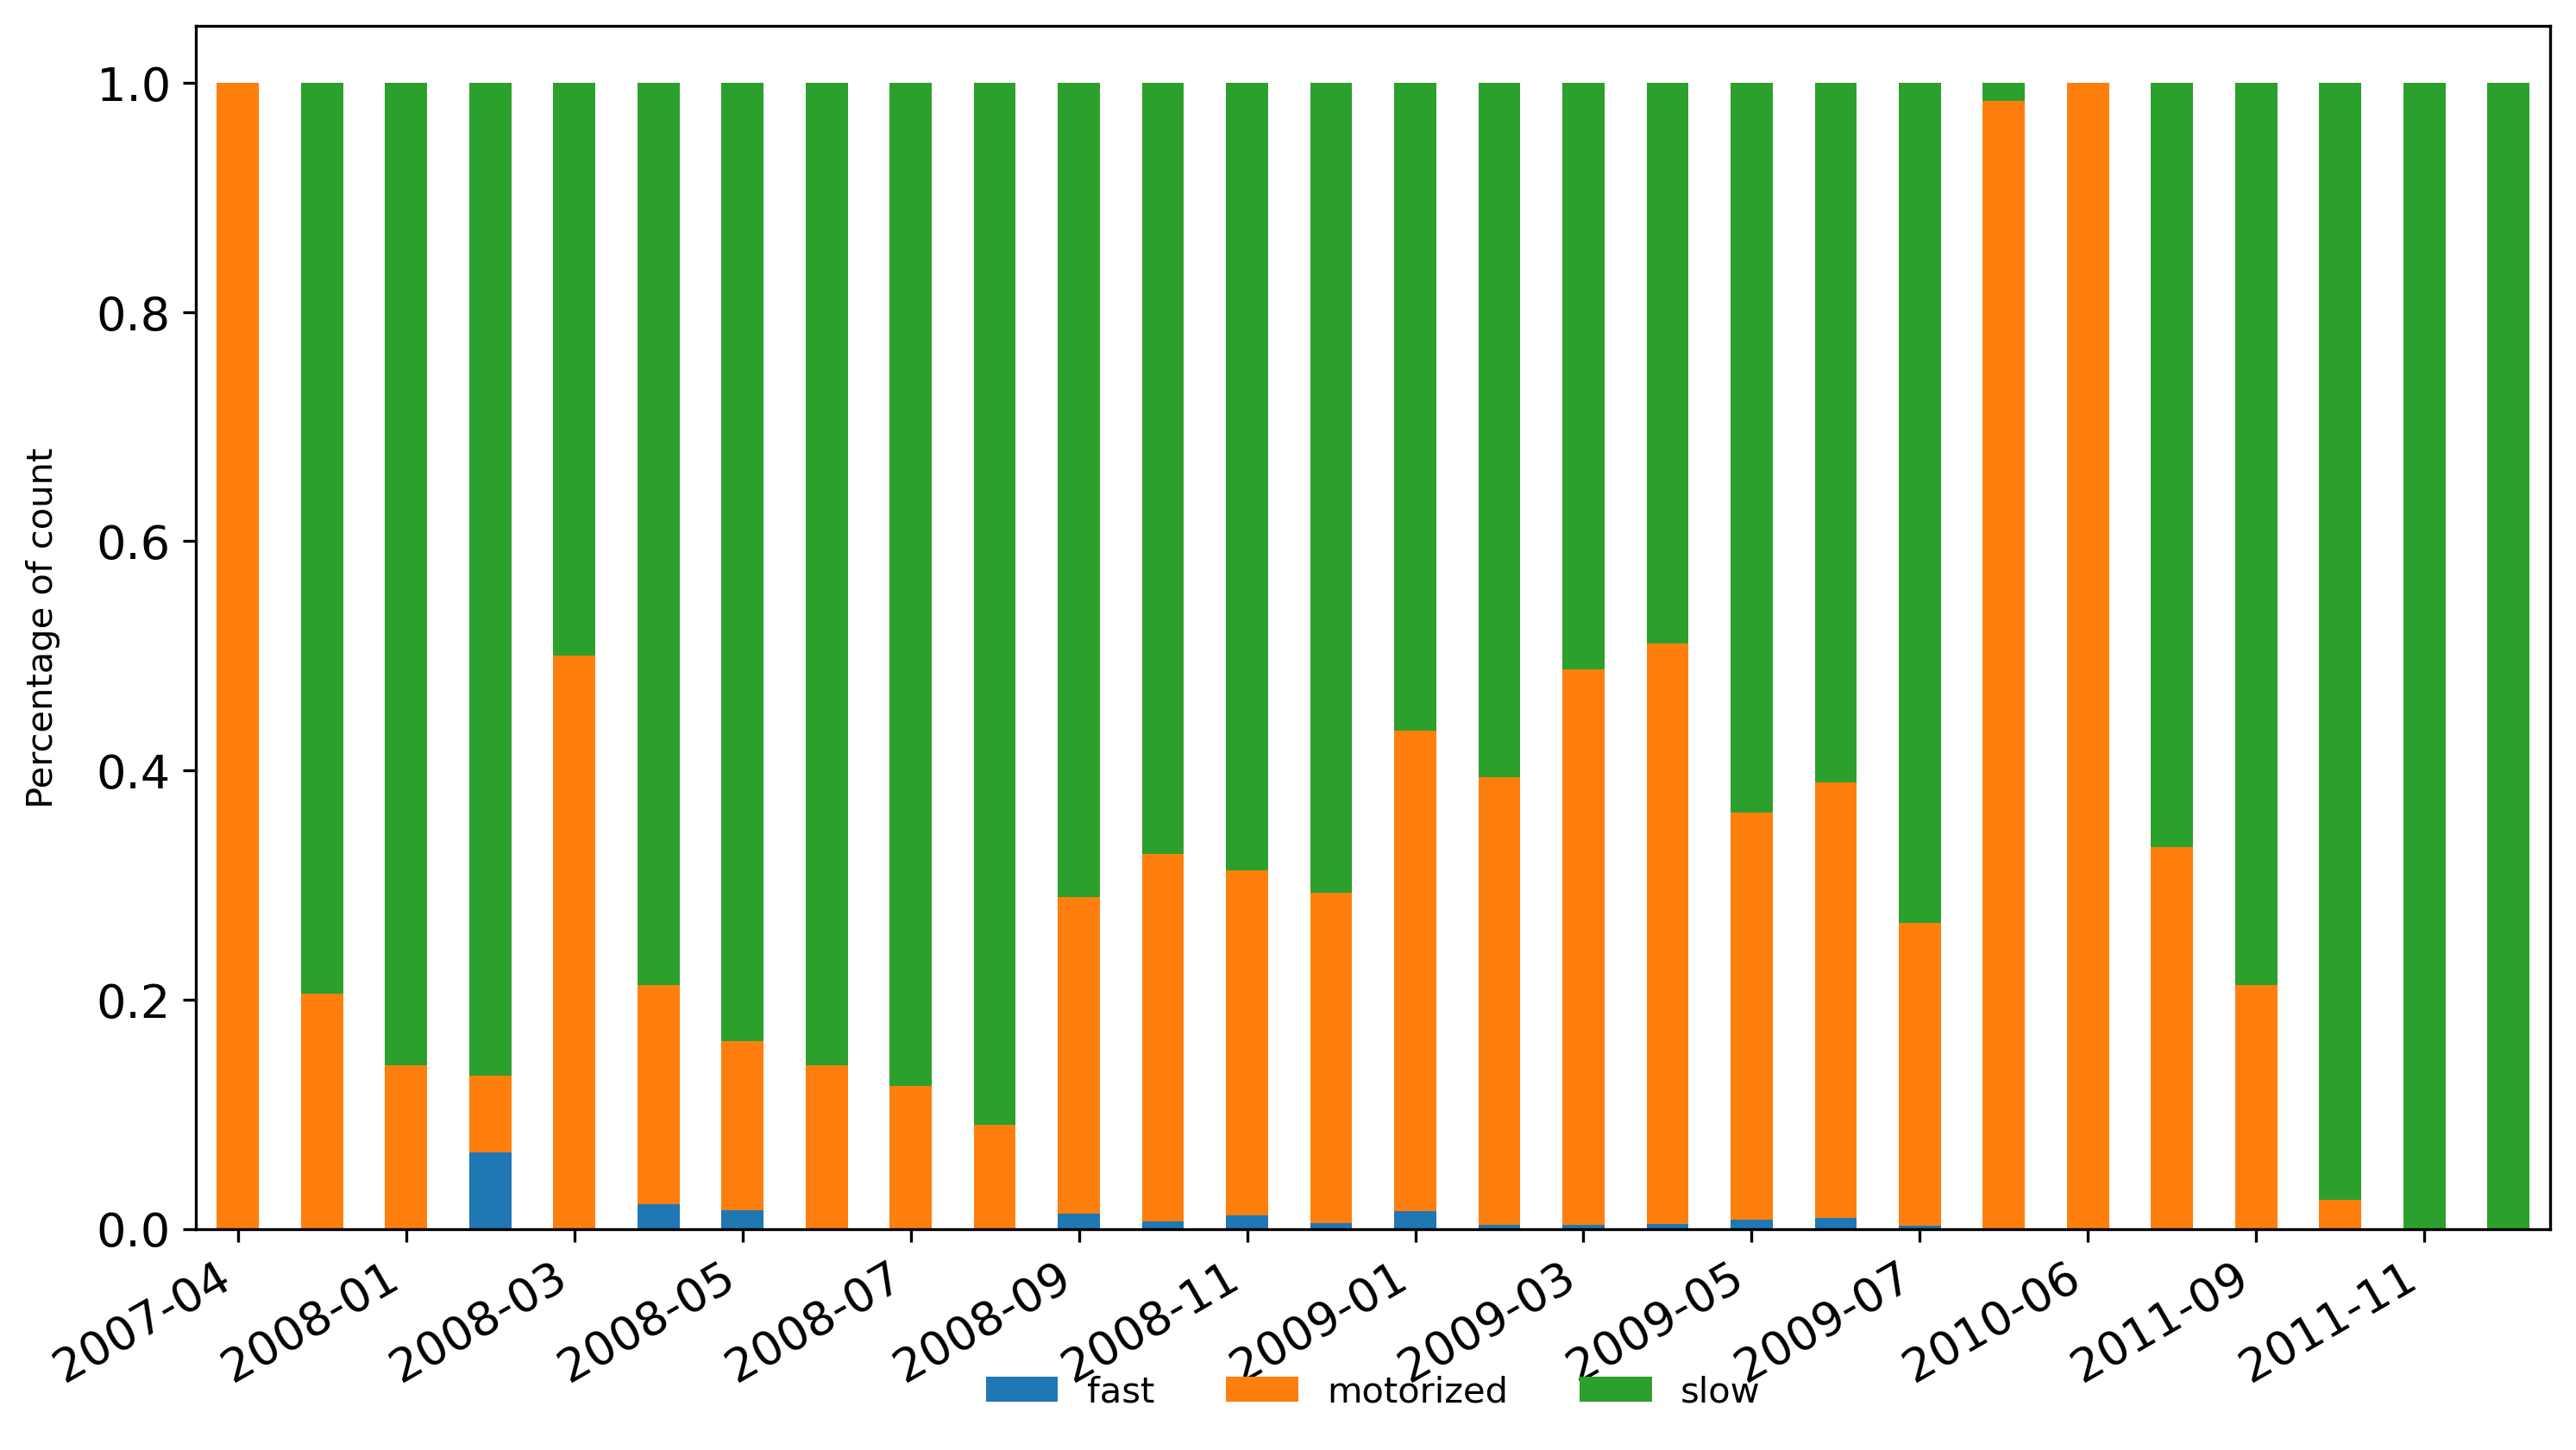

In [11]:
# count
modal_split_count = ti.analysis.calculate_modal_split(tpls, freq="M", metric="count", per_user=False, norm=True)

fig, ax = plt.subplots(figsize=(10, 6))
ax = ti.plot_modal_split(
    modal_split_count,
    date_fmt_x_axis="%Y-%m",
    y_label="Percentage of count",
    skip_xticks=2,
    n_col_legend=4,
    fig=fig,
    axis=ax,
    borderaxespad=2,
)
fig.autofmt_xdate()

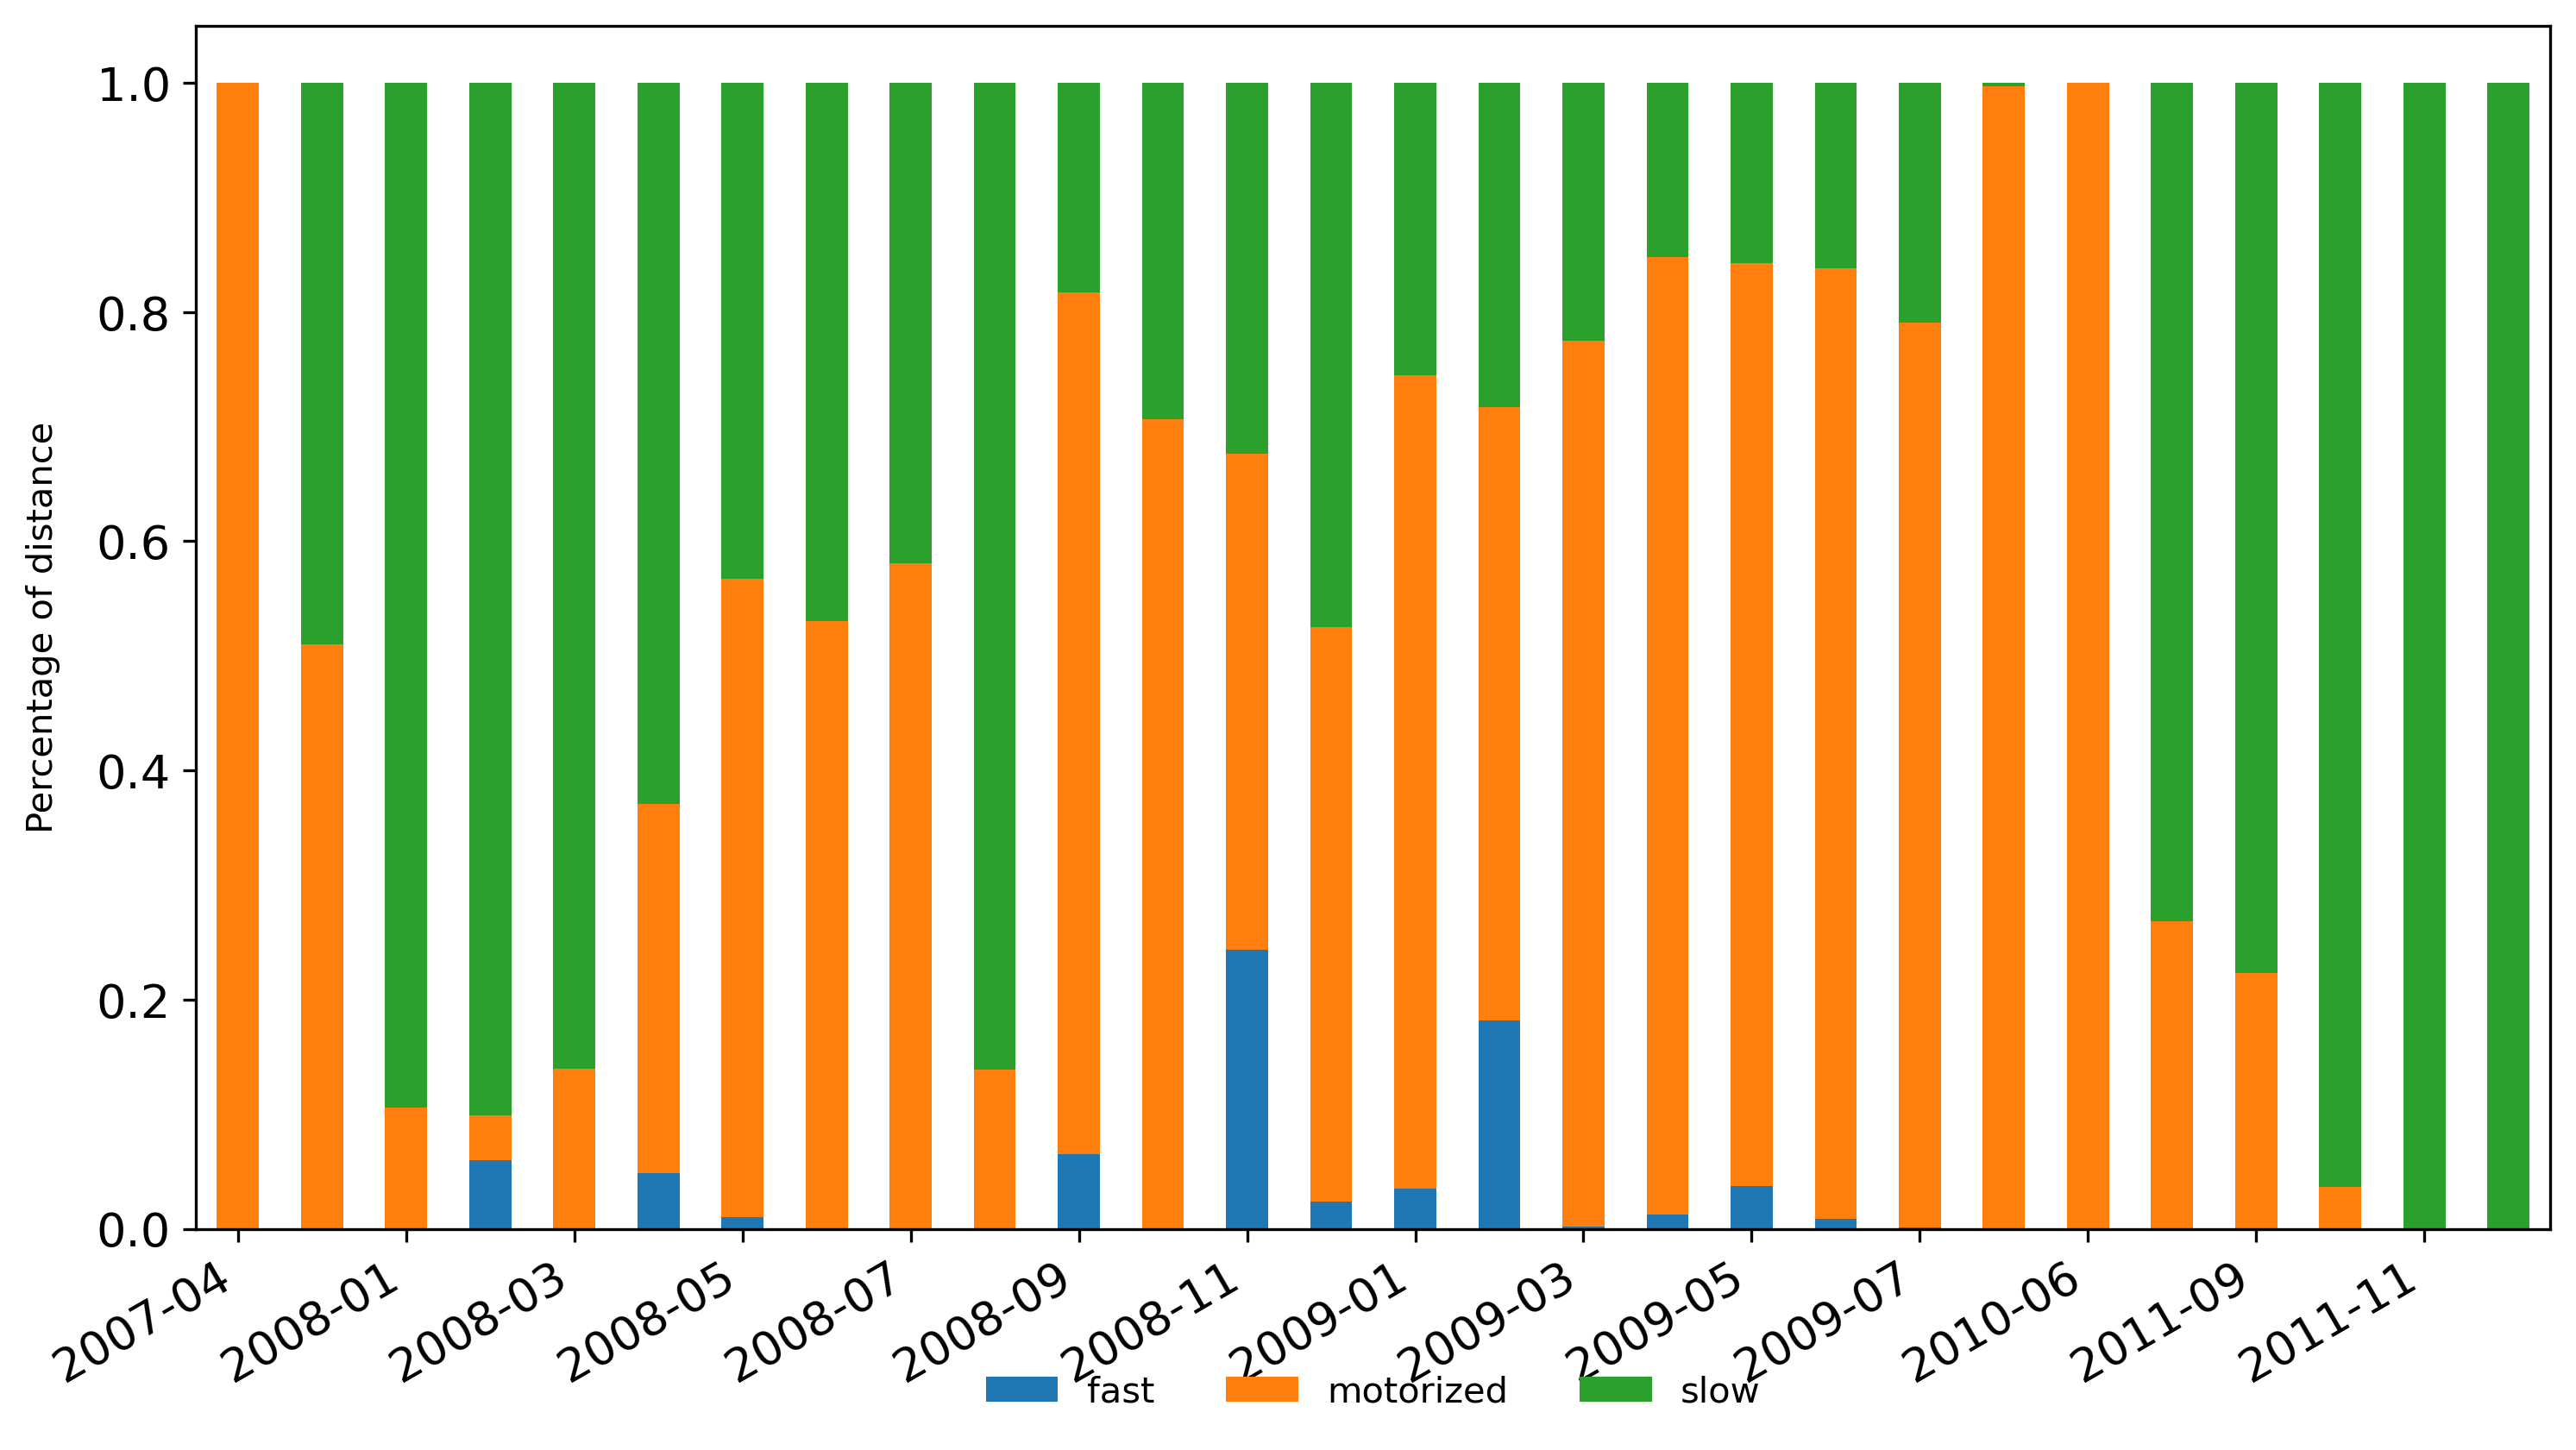

In [12]:
# distance
modal_split_distance = ti.analysis.calculate_modal_split(tpls, freq="M", metric="distance", per_user=False, norm=True)

fig, ax = plt.subplots(figsize=(10, 6))
ax = ti.plot_modal_split(
    modal_split_distance,
    date_fmt_x_axis="%Y-%m",
    y_label="Percentage of distance",
    skip_xticks=2,
    n_col_legend=4,
    fig=fig,
    axis=ax,
    borderaxespad=2,
)
fig.autofmt_xdate()

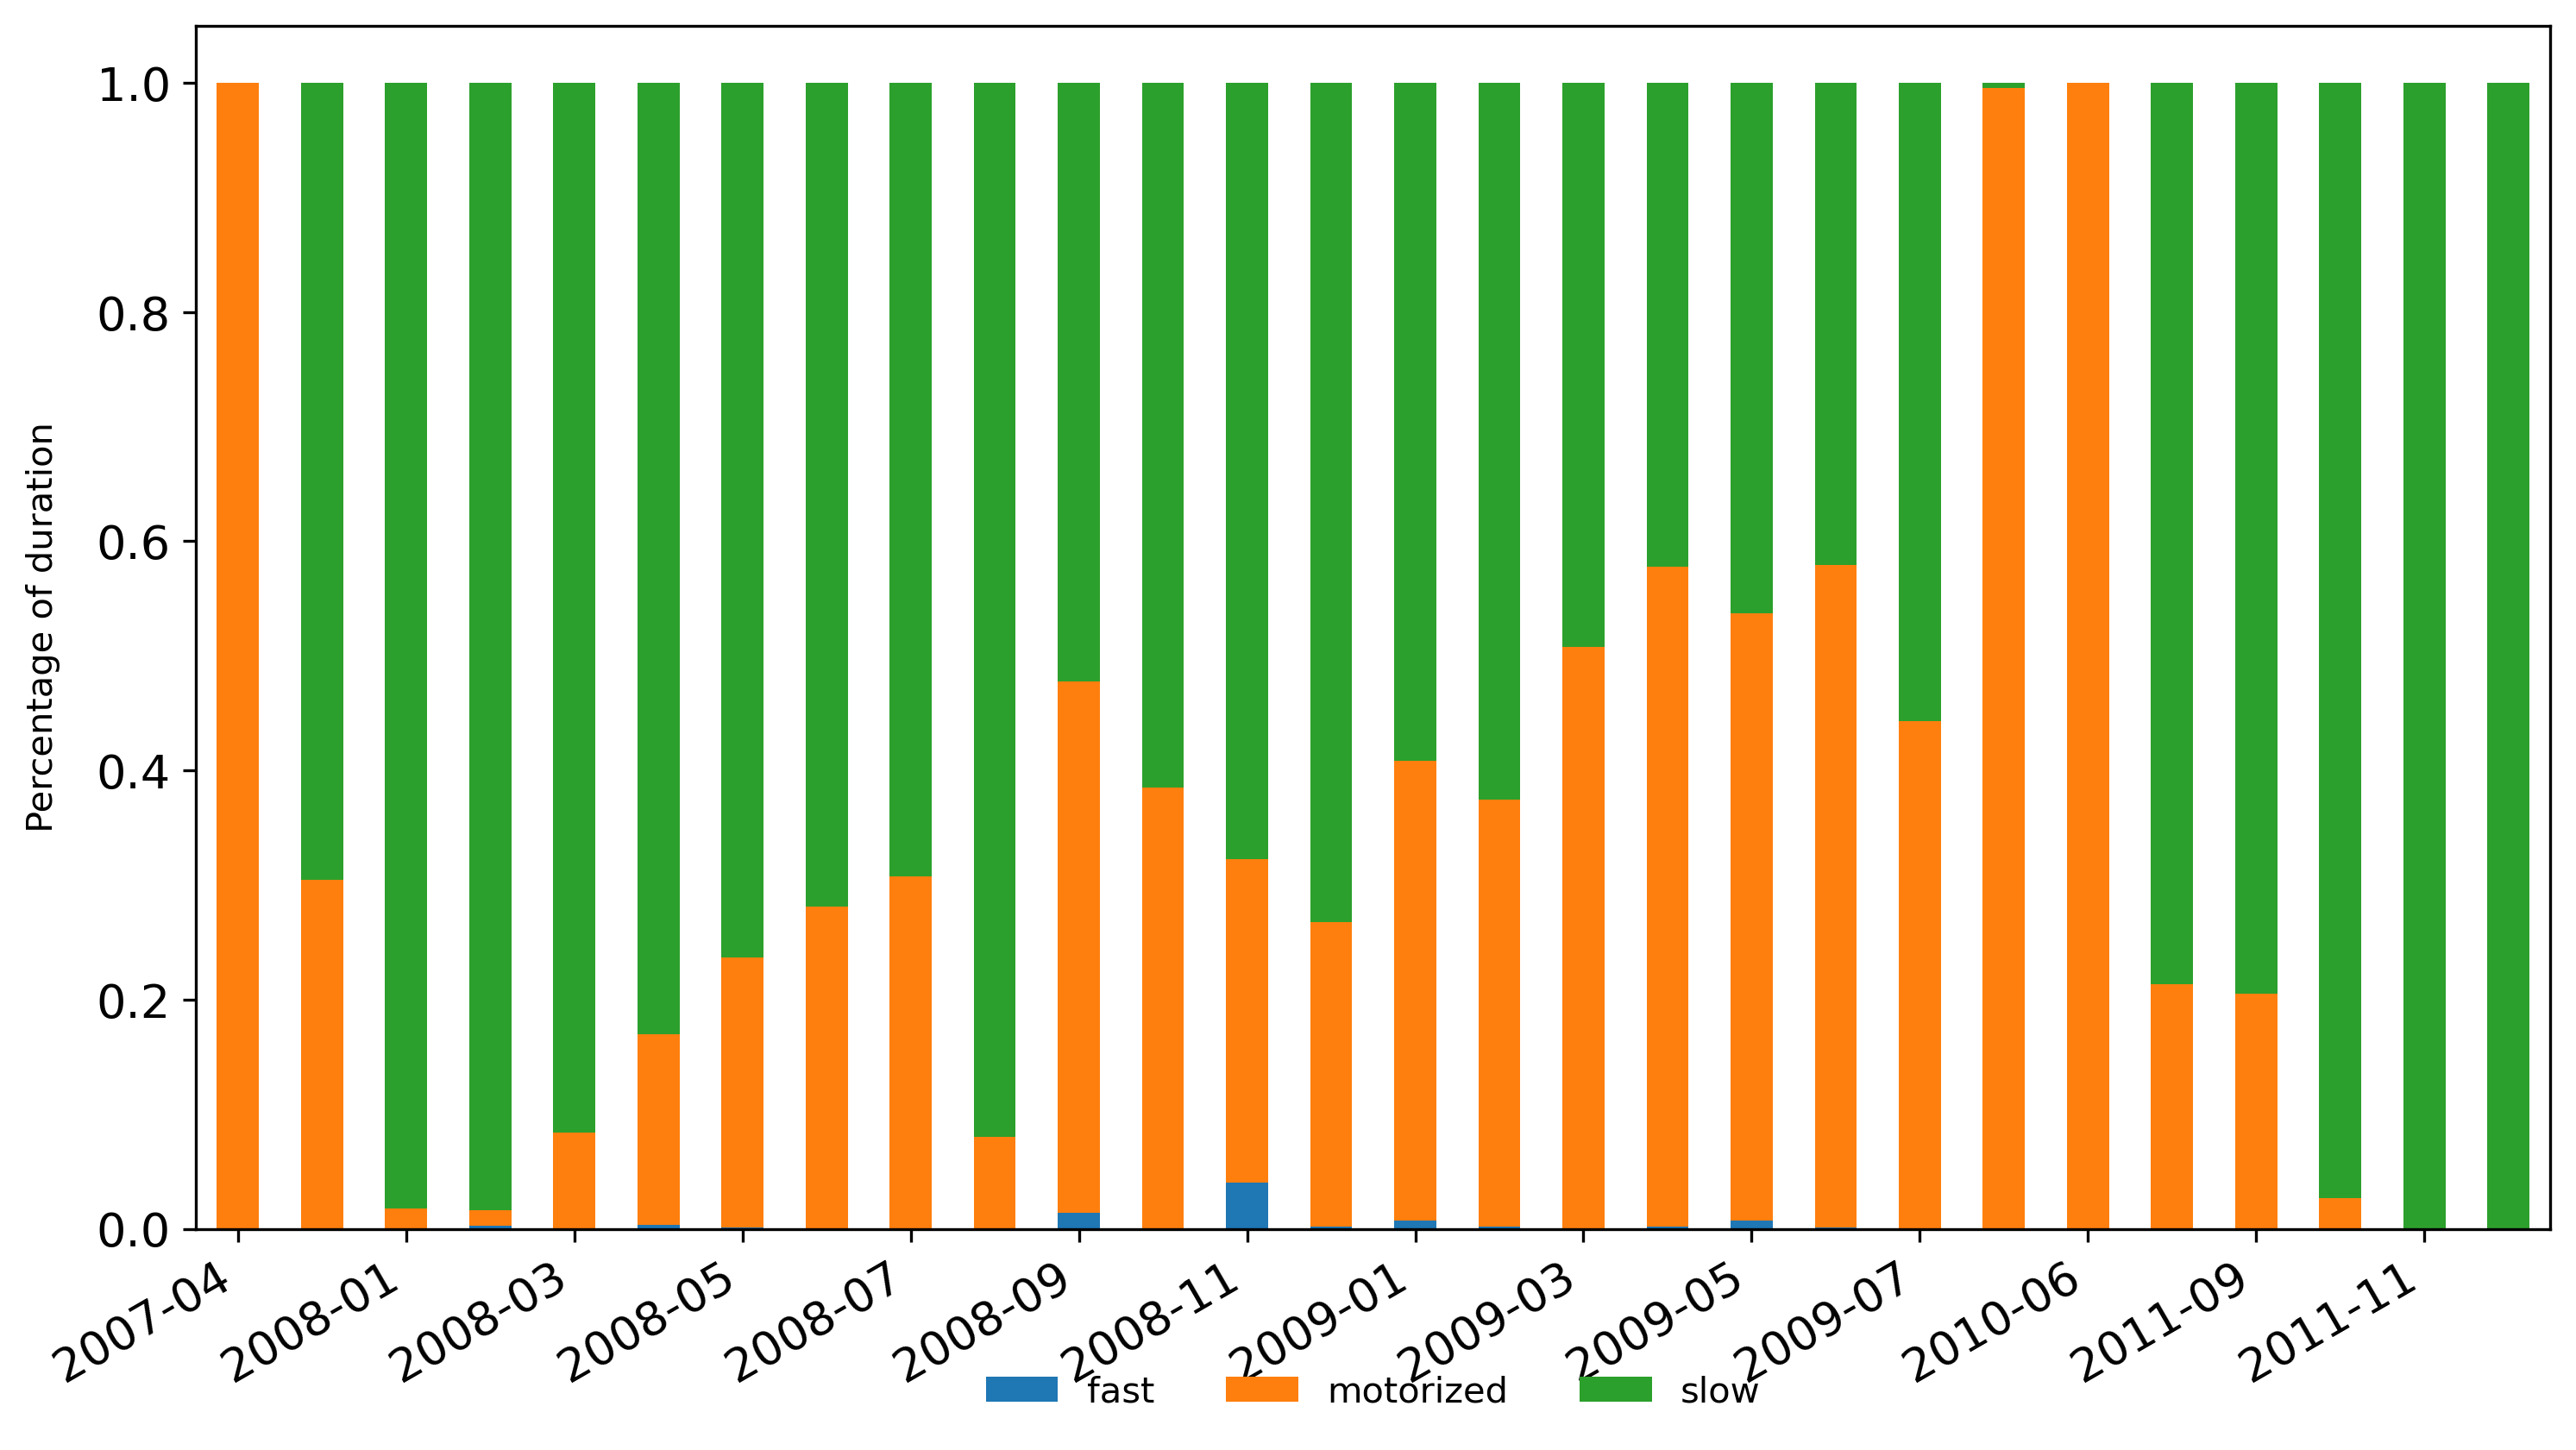

In [13]:
# duration
modal_split_duration = ti.analysis.calculate_modal_split(tpls, freq="M", metric="duration", per_user=False, norm=True)

fig, ax = plt.subplots(figsize=(10, 6))
ax = ti.plot_modal_split(
    modal_split_duration,
    date_fmt_x_axis="%Y-%m",
    y_label="Percentage of duration",
    skip_xticks=2,
    n_col_legend=4,
    fig=fig,
    axis=ax,
    borderaxespad=2,
)
fig.autofmt_xdate()

# Calculate Radius of Gyration
## Read files

In [17]:
selected_pfs = ti.read_positionfixes_csv(os.path.join(save_dir, "selected_geolife_pfs.csv"), index_col="id", crs="EPSG:4326")
selected_mode_labels = pickle.load(open(os.path.join(save_dir, "selected_mode_labels.pk"), "rb"))

# validate
len(selected_pfs), selected_mode_labels.keys()

(4396670, dict_keys([20, 112, 154]))

In [18]:
# generate staypoints
pfs, sp = selected_pfs.generate_staypoints(gap_threshold=24 * 60, include_last=True, print_progress=True, dist_threshold=200, time_threshold=30, n_jobs=-1)

c:\ProgramData\Anaconda3\envs\reprotrack\lib\site-packages\trackintel\preprocessing\positionfixes.py:113: UserWarning: 1690 duplicates were dropped from your positionfixes. Dropping duplicates is recommended but can be prevented using the 'exclude_duplicate_pfs' flag.
  warnings.warn(warn_str)
100%|██████████| 20/20 [00:00<00:00, 44.31it/s]


In [19]:
ti.analysis.radius_gyration(sp, method="count")

user_id
1        3807.411002
2      156783.324770
7       15384.407265
9        2083.680375
11       4847.303434
12     286497.804819
14       9860.180152
16       6380.351455
19       6716.494818
20       1644.603337
22     277949.908327
30      19698.118760
35       2199.804218
39      18519.945239
41      34997.994471
103     19440.726376
112      6634.762060
113      5172.946932
154     59965.266455
169      5955.636287
Name: radius_gyration, dtype: float64

In [26]:
sp["duration"] = (sp["finished_at"] - sp["started_at"])

In [27]:
ti.analysis.radius_gyration(sp, method="duration")

user_id
1        2555.886949
2      141198.752644
7       13553.414520
9        1018.344049
11       4754.886298
12     186413.225495
14       8555.789344
16       7210.718648
19       6092.686357
20       1654.699671
22     279212.826582
30      25388.192564
35       2341.146492
39      17311.886386
41      28546.339318
103     15555.883922
112      3547.498514
113      5115.375339
154     55885.293697
169      5419.747608
Name: radius_gyration, dtype: float64

# Calculate Jump length
## Read files

In [28]:
selected_pfs = ti.read_positionfixes_csv(os.path.join(save_dir, "selected_geolife_pfs.csv"), index_col="id", crs="EPSG:4326")
selected_mode_labels = pickle.load(open(os.path.join(save_dir, "selected_mode_labels.pk"), "rb"))

# validate
len(selected_pfs), selected_mode_labels.keys()

(4396670, dict_keys([20, 112, 154]))

In [29]:
# generate staypoints
pfs, sp = selected_pfs.generate_staypoints(gap_threshold=24 * 60, include_last=True, print_progress=True, dist_threshold=200, time_threshold=30, n_jobs=-1)

c:\ProgramData\Anaconda3\envs\reprotrack\lib\site-packages\trackintel\preprocessing\positionfixes.py:113: UserWarning: 1690 duplicates were dropped from your positionfixes. Dropping duplicates is recommended but can be prevented using the 'exclude_duplicate_pfs' flag.
  warnings.warn(warn_str)
100%|██████████| 20/20 [00:00<00:00, 46.31it/s]


In [31]:
sp["jumplength"] = ti.analysis.jump_length(sp)

In [32]:
sp

,user_id,started_at,finished_at,geom,jumplength
id,,,,,
0,1,2008-10-23 06:01:05+00:00,2008-10-23 10:32:53+00:00,POINT (116.32734 39.97835),4319.333786
1,1,2008-10-23 11:10:09+00:00,2008-10-23 23:46:02+00:00,POINT (116.30655 40.01378),4212.308029
2,1,2008-10-24 00:12:30+00:00,2008-10-24 01:48:57+00:00,POINT (116.32608 39.97897),1405.702677
3,1,2008-10-24 01:56:47+00:00,2008-10-24 02:28:19+00:00,POINT (116.30986 39.98129),54.774376
4,1,2008-10-24 02:28:19+00:00,2008-10-24 03:18:23+00:00,POINT (116.30927 39.98149),1480.716866
...,...,...,...,...,...
5177,169,2010-06-01 01:52:08+00:00,2010-06-02 01:29:27+00:00,POINT (116.33097 39.97549),14.804733
5178,169,2010-06-02 01:57:21+00:00,2010-06-02 10:21:51+00:00,POINT (116.33113 39.97543),3909.803948
5179,169,2010-06-02 10:40:25+00:00,2010-06-03 00:52:03+00:00,POINT (116.37678 39.97194),22.821229


# Activity prediction - trajectory context integration with OSM data